In [29]:
import numpy as np

def buggy_pca(X, d):
    # Apply PCA directly on the matrix X
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    Z = U[:, :d] * S[:d]
    V = Vt.T[:, :d]
    reconstruction = Z @ V.T
    return Z, V, reconstruction

def demeaned_pca(X, d):
    # Subtract the mean along each dimension
    mean_X = np.mean(X, axis=0)
    X_demeaned = X - mean_X
    U, S, Vt = np.linalg.svd(X_demeaned, full_matrices=False)
    Z = U[:, :d] * S[:d]
    V = Vt.T[:, :d]
    reconstruction = (Z @ V.T) + mean_X
    return Z, V, reconstruction

def normalized_pca(X, d):
    # Subtract the mean and scale each dimension
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    X_normalized = (X - mean_X) / std_X
    U, S, Vt = np.linalg.svd(X_normalized, full_matrices=False)
    Z = U[:, :d] * S[:d]
    V = Vt.T[:, :d]
    reconstruction = (Z @ V.T) * std_X + mean_X
    return Z, V, reconstruction

def dro(X, d):
    # DRO method
    n, D = X.shape
    # Start with demeaned PCA to initialize A and Z
    mean_X = np.mean(X, axis=0)
    X_demeaned = X - mean_X
    U, S, Vt = np.linalg.svd(X_demeaned, full_matrices=False)
    Z = U[:, :d] * S[:d]
    A = Vt[:d, :].T
    
    # Enforce the constraints that Z's mean is 0 and covariance is identity
    Z -= np.mean(Z, axis=0)
    cov_Z = np.cov(Z.T, bias=True)
    if d == 1:
        A /= np.sqrt(cov_Z)
        Z /= np.sqrt(cov_Z)
    else:
        A /= np.sqrt(np.diag(cov_Z))
        Z = Z @ np.linalg.inv(np.diag(np.sqrt(np.diag(cov_Z))))
    
    # The offset b is the mean of the original data
    b = mean_X
    # Compute the reconstruction
    reconstruction = Z @ A.T + b
    return Z, (A, b), reconstruction


def dro(X, d, epsilon=1e-6):
    # Number of samples
    n = X.shape[0]

    # Compute median and MAD for robust centering and scaling
    b = np.median(X, axis=0) 
    mad = np.median(np.abs(X - b), axis=0) + epsilon  # Ensure non-zero MAD

    # Center and scale the data
    X_centered = X - b
    X_scaled = X_centered / mad

    # Compute the robust covariance matrix
    # Weights are computed using broadcasting, and each feature's weights are normalized to sum to 1
    weights = 1 / (np.abs(X_scaled) + epsilon)
    weights /= np.sum(weights, axis=0, keepdims=True)  # Normalize weights for each feature
    robust_cov = (X_scaled.T * weights.T) @ X_scaled

    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(robust_cov)
    # Select the top d components based on the eigenvalues
    idx = np.argsort(eigenvalues)[::-1][:d]
    A = eigenvectors[:, idx]  # A contains the selected eigenvectors

    # Project data onto the selected components
    Z = X_scaled @ A

    # Reconstruct data from the lower-dimensional representation
    X_reconstructed = (Z @ A.T) * mad + b

    return Z, (A, b), X_reconstructed

In [30]:
# Example usage with dummy data and d=2
X_dummy = np.random.rand(10, 2)  # 10 samples in 5 dimensions
d = 1

# Apply each method to the dummy data
Z_buggy, V_buggy, recon_buggy = buggy_pca(X_dummy, d)
Z_demeaned, V_demeaned, recon_demeaned = demeaned_pca(X_dummy, d)
Z_normalized, V_normalized, recon_normalized = normalized_pca(X_dummy, d)
Z_dro, params_dro, recon_dro = dro(X_dummy, d)

# Printing the reconstructed data as an example
recon_buggy, recon_demeaned, recon_normalized, recon_dro
print(np.sum(np.linalg.norm(X_dummy - recon_demeaned, axis=1)**2))
print(np.sum(np.linalg.norm(X_dummy - recon_dro, axis=1)**2))

0.355804535499299
0.5721013066089585


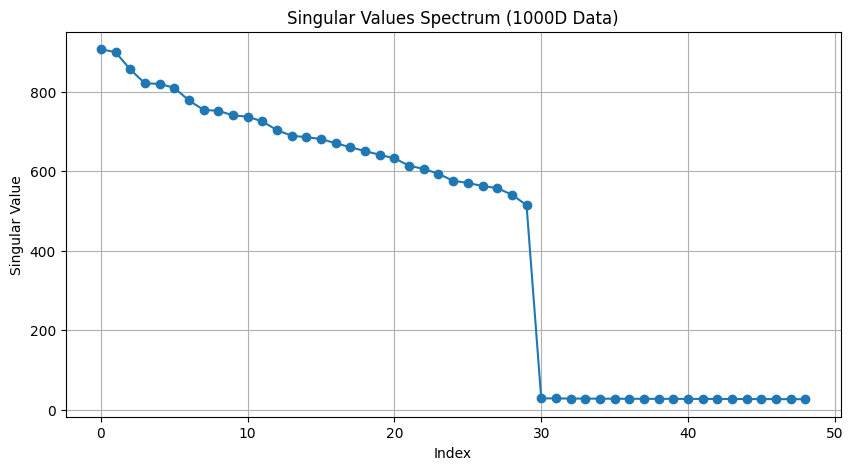

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
data2D = pd.read_csv(r'C:\Users\Nicor\OneDrive\Documents\Sem 9\ECE 760\HW5\data\data2D.csv', header=None).values
data1000D = pd.read_csv(r'C:\Users\Nicor\OneDrive\Documents\Sem 9\ECE 760\HW5\data\data1000D.csv', header=None).values

# Get singular values
_, S, _ = np.linalg.svd(data1000D, full_matrices=False)

# Plot the singular values to identify the knee point
plt.figure(figsize=(10, 5))
plt.plot(S[1:50], 'o-')
plt.title('Singular Values Spectrum (1000D Data)')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

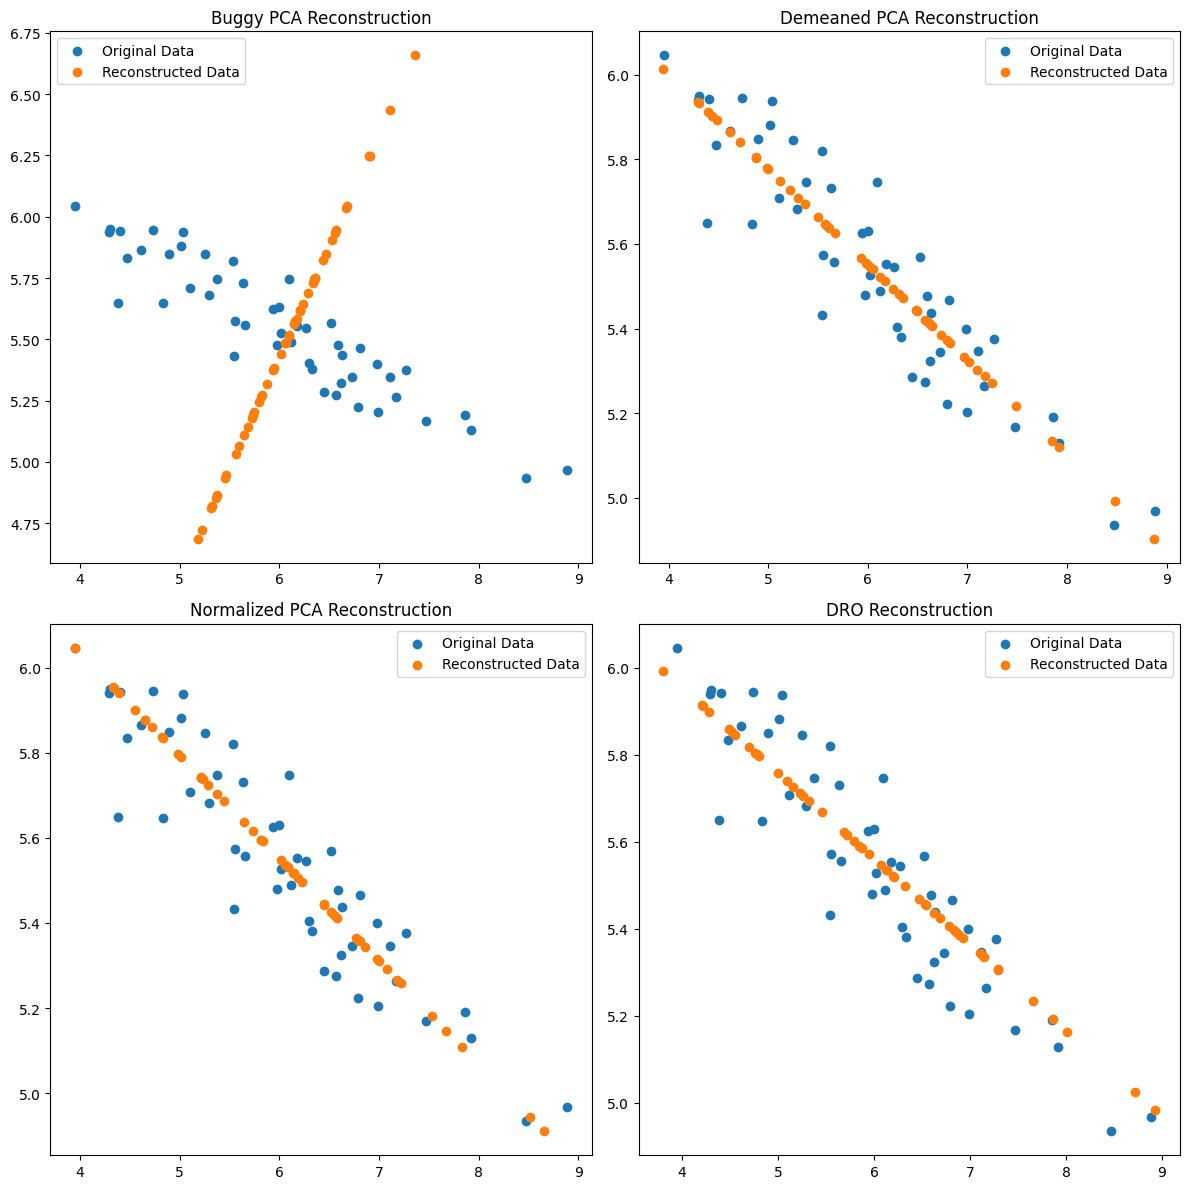

In [33]:

def reconstruction_error(X, reconstructed_X):
    # Calculate the reconstruction error
    return np.sum(np.linalg.norm(X - reconstructed_X, axis=1)**2)

# Apply the methods to the 2D dataset with d=1
Z_buggy_2D, V_buggy_2D, recon_buggy_2D = buggy_pca(data2D, d=1)
Z_demeaned_2D, V_demeaned_2D, recon_demeaned_2D = demeaned_pca(data2D, d=1)
Z_normalized_2D, V_normalized_2D, recon_normalized_2D = normalized_pca(data2D, d=1)
Z_dro_2D, params_dro_2D, recon_dro_2D = dro(data2D, d=1)

# Calculate reconstruction errors for the 2D dataset
recon_error_buggy_2D = reconstruction_error(data2D, recon_buggy_2D)
recon_error_demeaned_2D = reconstruction_error(data2D, recon_demeaned_2D)
recon_error_normalized_2D = reconstruction_error(data2D, recon_normalized_2D)
recon_error_dro_2D = reconstruction_error(data2D, recon_dro_2D)

# Now, let's do the same for the 1000D dataset with the chosen d=31
Z_buggy_1000D, V_buggy_1000D, recon_buggy_1000D = buggy_pca(data1000D, d=31)
Z_demeaned_1000D, V_demeaned_1000D, recon_demeaned_1000D = demeaned_pca(data1000D, d=31)
Z_normalized_1000D, V_normalized_1000D, recon_normalized_1000D = normalized_pca(data1000D, d=31)
Z_dro_1000D, params_dro_1000D, recon_dro_1000D = dro(data1000D, d=31)

# Calculate reconstruction errors for the 1000D dataset
recon_error_buggy_1000D = reconstruction_error(data1000D, recon_buggy_1000D)
recon_error_demeaned_1000D = reconstruction_error(data1000D, recon_demeaned_1000D)
recon_error_normalized_1000D = reconstruction_error(data1000D, recon_normalized_1000D)
recon_error_dro_1000D = reconstruction_error(data1000D, recon_dro_1000D)

# Now let's plot the original vs reconstructed points for the 2D dataset
plt.figure(figsize=(12, 12))

# Buggy PCA
plt.subplot(2, 2, 1)
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original Data')
plt.scatter(recon_buggy_2D[:, 0], recon_buggy_2D[:, 1], label='Reconstructed Data')
plt.title('Buggy PCA Reconstruction')
plt.legend()

# Demeaned PCA
plt.subplot(2, 2, 2)
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original Data')
plt.scatter(recon_demeaned_2D[:, 0], recon_demeaned_2D[:, 1], label='Reconstructed Data')
plt.title('Demeaned PCA Reconstruction')
plt.legend()

# Normalized PCA
plt.subplot(2, 2, 3)
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original Data')
plt.scatter(recon_normalized_2D[:, 0], recon_normalized_2D[:, 1], label='Reconstructed Data')
plt.title('Normalized PCA Reconstruction')
plt.legend()

# DRO
plt.subplot(2, 2, 4)
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original Data')
plt.scatter(recon_dro_2D[:, 0], recon_dro_2D[:, 1], label='Reconstructed Data')
plt.title('DRO Reconstruction')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
recon_error_buggy_2D , recon_error_demeaned_2D, recon_error_normalized_2D , recon_error_dro_2D

(44.345154186739705, 0.5003042814256455, 2.4736041727385354, 2.145464039764822)

In [35]:
recon_error_buggy_1000D ,recon_error_demeaned_1000D,recon_error_normalized_1000D, recon_error_dro_1000D

(136384.97461090726, 135697.802110637, 136029.46338770172, 1164682.722473349)